In [13]:
import os, subprocess

In [14]:
def make_input(input_dictionary):
    os.chdir("/Applications/CEA")
    filename = "rocket"+str(input_dictionary["case number"])+".inp"
    #return (input_dictionary["case number"],input_dictionary["OFratio"],input_dictionary["chamber-to-throat area ratio"],input_dictionary["chamber temperature"],input_dictionary["pressure ratio"],input_dictionary["fuel"],input_dictionary["oxidizer"])
    text = """problem   case={} o/f={},\n    rocket  fac   ac/at={}  tcest,k={}\n  p,psia={},\n  pi/p={},
react  \n  fuel={} moles=1.  t,k={}  \n  oxid={} moles=1.  \nonly \n  Ar C CO CO2 H H2 H2O HNO HO2 HNO2 HNO3 N NH NO N2 N2O3 O O2 OH O3 \noutput  massf transport \n    plot isp \nend"""
    text = text.format(input_dictionary["case number"],
                       input_dictionary["OFratio"],
                       input_dictionary["chamber-to-throat area ratio"],
                       input_dictionary["chamber temperature"],
                       input_dictionary["chamber pressure"],
                       input_dictionary["pressure ratio"],
                       input_dictionary["fuel"],
                       input_dictionary["fuel temperature"],
                       input_dictionary["oxidizer"])
    with open(filename,"w") as f:
        data = f.write(text)
    return filename
        
def runCEA(filename):
    filename_no_extension = filename.split('.inp')[0]
    p = subprocess.Popen(['FCEA2'], stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_data = p.communicate(input=filename_no_extension.encode('utf-8'))[0]
    return filename_no_extension+".out"
    
def extract_values(filename):
    output_dict = {}
    with open(filename) as f:
        text = f.read()
        #extract injector and chamber temperatures
        s = text.split("T, K")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 1:
                    output_dict["injector temperature"] = float(token)
                elif i == 2:
                    output_dict["chamber end temperature"] = float(token)
                    break
        #extract Ae/At
        s = text.split("Ae/At")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["throat-to-exit area ratio"] = float(token)
                    break
        #extract Cstar
        s = text.split("CSTAR, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 1:
                    output_dict["Cstar"] = float(token)
                    break
        #extract Ivac
        s = text.split("Ivac, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["Ivac"] = float(token)
                    break
        #extract Isp
        s = text.split("Isp, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["Isp"] = float(token)
                    break
        return output_dict
    
def runAll(input_dictionary):
    filename = make_input(input_dictionary)
    filename = runCEA(filename)
    return extract_values(filename)

In [15]:
input_dict = {"case number":2003,
              "OFratio":2.3,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":3446,
              "chamber pressure":300,
              "pressure ratio":20.4207459666,
              "fuel":"C8H18(L),n-octa",
              "fuel temperature":298,
              "oxidizer":"O2(L)"
             }
runAll(input_dict)

{'Cstar': 1805.7,
 'Isp': 2567.5,
 'Ivac': 2908.8,
 'chamber end temperature': 3366.14,
 'injector temperature': 3369.08,
 'throat-to-exit area ratio': 3.8352}

## Isp vs. O/F ratio

We assume a chamber pressure of 300 psi.

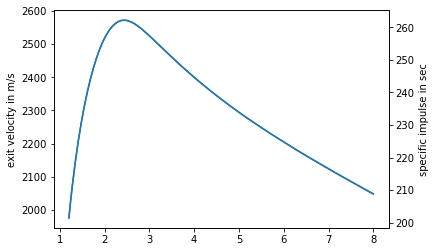

In [31]:
import matplotlib.pyplot as plt
import numpy as np


input_dict = {"case number":2003,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":3000,
              "chamber pressure":300,
              "pressure ratio":20.4207459666,
              "fuel":"C8H18(L),n-octa",
              "fuel temperature":298,
              "oxidizer":"O2(L)"
             }
OFratio = np.linspace(1.2,8.0,200)
Isp = []
for r in OFratio:
    input_dict["OFratio"] = r
    res = runAll(input_dict)["Isp"]
    Isp.append(res)
Isp = np.array(Isp)
fig, ax1 = plt.subplots()
ax1.plot(OFratio,Isp)
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(OFratio,Isp/9.81)
ax2.set_ylabel("specific impulse in sec")
plt.xlabel("O/F mass ratio")
plt.show()

This graph shows that a mass ratio of about 2.5 yields the maximum spcific impulse